<h1>Обучение модели прогнозирования температуры поверхности льда</h1>

Передача энергии от холодильной установки до поверхности льда имеет непостоянный инерционных характер, обусловленный нелинейными взаимосвязями различных внутренних воздействий. К примеру, передача тепловой энергии от компрессоров до верхней точки толщи ледового покрытия может составлять от 20 до 40 минут в зависимости от скорости прокачки гликоля, уставки давления внутри компрессоров и скорости работы тепловентиляторов системы охлаждения. При этом на ледовое покрытие оказывают внешние воздействия такие как: теплообмен с воздухом арены, интенсивность движения спортсменов и их количество, объем и температура проводимой заливки, последняя в свою очередь является резким возмущающим фактором, который приводит к моментальному увеличению температуры льда и отклонению его от целевых параметров.

In [42]:
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [82]:
data = pd.read_csv('../data/transformed_data.csv')

# <h1>Prepare time series data for Convolutional Neural Network and Long Short-Term Memory</h1>

Time series data must be transformed before it can be used to fit a supervised learning model.
In this form, the data can be used immediately to fit a supervised machine learning algorithm
and even a Multilayer Perceptron neural network. One further transformation is required in
order to ready the data for fitting a Convolutional Neural Network (CNN) or Long Short-Term
Memory (LSTM) Neural Network. Specifically, the two-dimensional structure of the supervised
learning data must be transformed to a three-dimensional structure. This is perhaps the largest
sticking point for practitioners looking to implement deep learning methods for time series
forecasting.

In [83]:
data.head()

,time,power_pump,temp_ice,temp_outside,hum_outside,temp_inside,hum_inside,max_motion,illuminance,CO2,temp_condensation,consumption_compressors,power_compressors,power_condensators,temp_supply_glycol,temp_return_glycol
0,2023-02-17 00:01:00,6844.409912,-3.578125,-7.95,79.0,7.15,38.225000,18.00,73.199997,425.500,13.103667,0.514583,30818.615547,6169.069941,-7.85,-5.31
1,2023-02-17 00:02:00,6860.609863,-3.609375,-7.95,79.0,7.15,38.750000,17.25,72.559998,426.875,12.223584,0.500000,30323.374219,6172.647412,-7.75,-5.31
2,2023-02-17 00:03:00,6856.255127,-3.619141,-7.95,79.0,7.15,39.174999,20.00,73.599997,427.000,7.812167,0.500000,29686.730156,4026.280020,-7.85,-5.31
3,2023-02-17 00:04:00,6870.135010,-3.611328,-7.95,79.0,7.15,38.700000,19.25,73.519997,429.000,7.431917,0.528906,31717.734297,4022.334907,-7.85,-5.31
4,2023-02-17 00:05:00,6868.975098,-3.603516,-7.95,79.0,7.15,38.474999,20.25,73.599997,430.500,11.624917,0.542448,32606.476172,5103.015059,-7.85,-5.31


## Convert time to sinusoidal and cosinusoidal signals

In [84]:
data['time'] = pd.to_datetime(data['time'])
timestamp_s = data['time'].map(pd.Timestamp.timestamp)
day = 24 * 60 * 60
data['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
data['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
data = data.drop(columns=['time', 'consumption_compressors'])

Text(0.5, 1.0, 'Time of day signal')

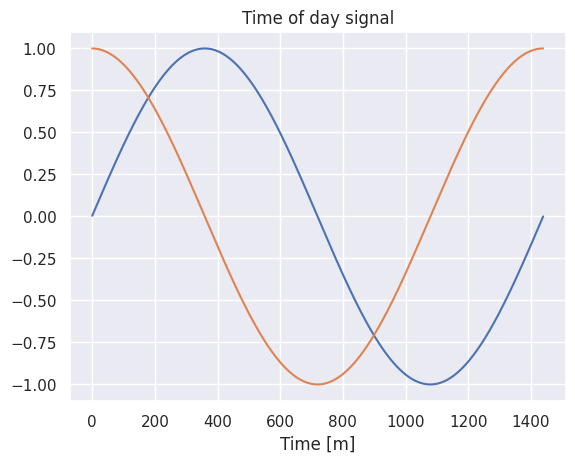

In [85]:
sns.set_theme()
plt.plot(np.array(data['day_sin'])[:1440])
plt.plot(np.array(data['day_cos'])[:1440])
plt.xlabel('Time [m]')
plt.title('Time of day signal')

## Split data to train, validation, test sets

In [86]:
column_indices = {name: i for i, name in enumerate(data.columns)}

n = len(data)
train_df = data[0: int(n * 0.7)]
val_df = data[int(n * 0.7): int(n * 0.9)]
test_df = data[int(n * 0.9): ]
num_features = data.shape[1]

In [87]:
column_indices

{'power_pump': 0,
 'temp_ice': 1,
 'temp_outside': 2,
 'hum_outside': 3,
 'temp_inside': 4,
 'hum_inside': 5,
 'max_motion': 6,
 'illuminance': 7,
 'CO2': 8,
 'temp_condensation': 9,
 'power_compressors': 10,
 'power_condensators': 11,
 'temp_supply_glycol': 12,
 'temp_return_glycol': 13,
 'day_sin': 14,
 'day_cos': 15}

## Data normalization

In [88]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

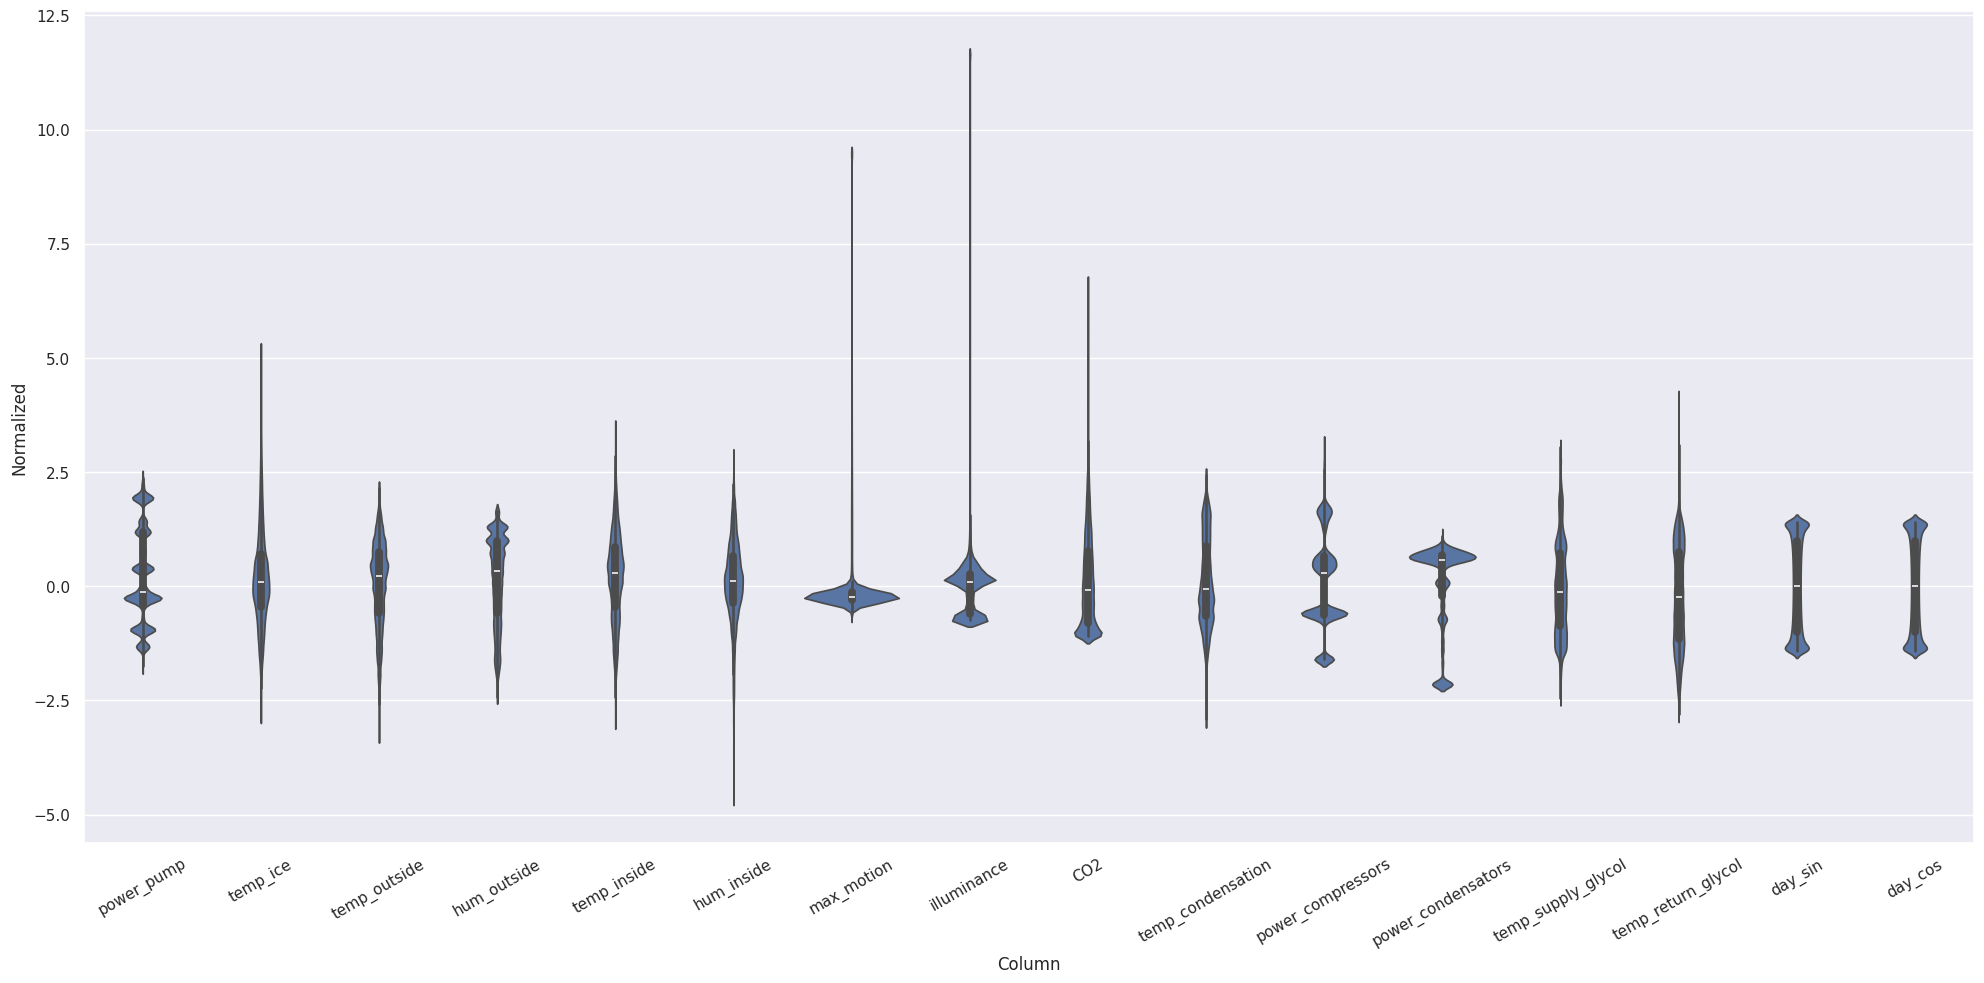

In [89]:
df_std = (data - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(20, 10))
plt.xticks(rotation=30)
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.xaxis.set_ticks(data.keys())
plt.tight_layout()

## Data window

In [117]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=None):
        # Store the raw data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
            self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    
    def __repr__(self):
        return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
        
        # Slicing doesn't preserve static hsapre information, so set the shapes manually.
        # This way the `tf.data.Dataset` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels


In [118]:
WindowGenerator(input_width=120, label_width=1, shift=30, label_columns=['temp_ice'])

Total window size: 150
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [149]
Label column name(s): ['temp_ice']

In [119]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=['temp_ice'])
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 16)
Inputs shape: (3, 6, 16)
Labels shape: (3, 1, 1)
